# Data Preparing

In [1]:
!pip install datasets evaluate --upgrade -q
!pip install spacy --upgrade -q
!pip install torchtext==0.17.0 -q
!python -m spacy download en_core_web_sm
!python -m spacy download de_core_news_sm


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python -m pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python -m pip install --upgrade pip

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python -m pip install --upgrade pip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 201.6 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python -m pip install --upgrade pip
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 107.5 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python -m pip install --upgrade pip
✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_sm')


In [2]:
import math
import random
import numpy as np

import spacy
import datasets
from torchtext import vocab

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import tqdm

In [3]:
dataset = datasets.load_dataset("bentrevett/multi30k")

train_data, valid_data, test_data = (
    dataset["train"],
    dataset["validation"],
    dataset["test"],
)

Generating train split:   0%|          | 0/29000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1014 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [4]:
from functools import partial

def tokenize_and_lower(s, key):
    global en_nlp, de_nlp, max_length

    if key == 'en':
        nlp = en_nlp
        text = s['en']
    elif key == 'de':
        nlp = de_nlp
        text = s['de']
    else:
        raise ValueError("Invalid key. Expected 'en' or 'de'.")

    return [token.text.lower() for token in nlp.tokenizer(text)][:max_length]

tokenize_en = partial(tokenize_and_lower, key='en')
tokenize_de = partial(tokenize_and_lower, key='de')

en_nlp = spacy.load("en_core_web_sm")
de_nlp = spacy.load("de_core_news_sm")

min_freq = 2
max_length = 100
convert_to_lowercase = True
sos_token = "<sos>"
eos_token = "<eos>"
unk_token = "<unk>"
pad_token = "<pad>"
special_tokens = [
    unk_token,
    pad_token,
    sos_token,
    eos_token,
]

en_tokens = [tokenize_en(s) for s in train_data]
en_vocab = vocab.build_vocab_from_iterator(
    en_tokens,
    min_freq=min_freq,
    specials=special_tokens,
)

de_tokens = [tokenize_de(s) for s in train_data]
de_vocab = vocab.build_vocab_from_iterator(
    de_tokens,
    min_freq=min_freq,
    specials=special_tokens,
)

unk_index = en_vocab[unk_token]
pad_index = en_vocab[pad_token]

en_vocab.set_default_index(unk_index)
de_vocab.set_default_index(unk_index)


In [5]:
def preprocess_and_tokenize(example, en_nlp, de_nlp, max_length, sos_token, eos_token, en_vocab, de_vocab):
    en_tokens = [sos_token] + tokenize_en(example) + [eos_token]
    de_tokens = [sos_token] + tokenize_de(example) + [eos_token]
    en_ids = en_vocab.lookup_indices(en_tokens)
    de_ids = de_vocab.lookup_indices(de_tokens)

    return {"en_tokens": en_tokens, "de_tokens": de_tokens, "en_ids": en_ids, "de_ids": de_ids}


function_kwargs = {
    "en_nlp": en_nlp,
    "de_nlp": de_nlp,
    "max_length": max_length,
    "sos_token": sos_token,
    "eos_token": eos_token,
    "en_vocab": en_vocab,
    "de_vocab": de_vocab
}

train_data = train_data.map(preprocess_and_tokenize, fn_kwargs=function_kwargs)
valid_data = valid_data.map(preprocess_and_tokenize, fn_kwargs=function_kwargs)
test_data = test_data.map(preprocess_and_tokenize, fn_kwargs=function_kwargs)

Map:   0%|          | 0/29000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1014 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [6]:
data_type = "torch"
format_columns = ["en_ids", "de_ids"]

kwargs = {
    "type": "torch",
    "columns": ["en_ids", "de_ids"],
    "output_all_columns": True
}

train_data = train_data.with_format(**kwargs)
valid_data = valid_data.with_format(**kwargs)
test_data = test_data.with_format(**kwargs)

In [7]:
def create_collate_function(pad_value):
    def collate_batch(batch):
        english_ids = [example["en_ids"] for example in batch]
        german_ids = [example["de_ids"] for example in batch]

        padded_english_ids = nn.utils.rnn.pad_sequence(english_ids, padding_value=pad_value, batch_first=True)
        padded_german_ids = nn.utils.rnn.pad_sequence(german_ids, padding_value=pad_value, batch_first=True)

        return {
            "en_ids": padded_english_ids,
            "de_ids": padded_german_ids,
        }

    return collate_batch

def create_data_loader(dataset, batch_size, pad_value, shuffle=False):
    collate_function = create_collate_function(pad_value)
    data_loader = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        collate_fn=collate_function,
        shuffle=shuffle,
    )
    return data_loader

batch_size = 128
pad_value = 0

train_loader = create_data_loader(train_data, batch_size, pad_value, shuffle=True)
valid_loader = create_data_loader(valid_data, batch_size, pad_value)
test_loader = create_data_loader(test_data, batch_size, pad_value)


# Modeling

## Positional Encoding

$ PE_{(pos, 2i)} = sin(pos/10000^{2i/d_{model}}) $

$ PE_{(pos, 2i+1)} = cos(pos/10000^{2i/d_{model}}) $

In [8]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_len=5000):
        super(PositionalEncoding, self).__init__()

        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.encoding = torch.zeros(max_seq_len, d_model).to(self.device)

        position = torch.arange(0, max_seq_len, dtype=torch.float).unsqueeze(1).to(self.device)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model)).to(self.device)

        self.encoding[:, 0::2] = torch.sin(position * div_term)
        self.encoding[:, 1::2] = torch.cos(position * div_term)

        self.encoding = self.encoding.unsqueeze(0)

    def forward(self, x):
        return x + self.encoding[:, :x.size(1), :].to(self.device)

## MultiHeadAttention

### Scaled Dot-Product Attention 설명
**입력**
- Queries: $ d_k $ 크기의 벡터들
- Keys: $ d_k $ 크기의 벡터들
- Values: $ d_v $ 크기의 벡터들


**계산 과정**
- Queries와 Keys의 모든 쌍들의 내적(dot product)을 구함
- 각 내적 결과를 $\sqrt{d_k}$로 나눔
- Softmax 함수를 적용하여 가중치를 구함
- 가중치와 Values를 곱하여 최종 출력을 계산함

$ Attention(Q, K, V) = \text{softmax}(\frac{QK^T}{\sqrt{d_k}})V $

- $ Q $: Queries를 포함하는 행렬
- $ K $: Keys를 포함하는 행렬
- $ V $: Values를 포함하는 행렬
- $ \text{softmax} $: 각 요소가 확률이 되게 만드는 함수
- $ \sqrt{d_k} $: 내적 값들이 너무 커지는 것을 방지하기 위해 나누는 값

### Multi-Head Attention 설명
- **멀티헤드 어텐션 개요**
  - 단일 어텐션 함수 사용 대신, $ d_{model}$ 차원의 키(keys), 값(values), 쿼리(queries)를 $h$번 다른 선형 투영합니다.
  - 각 투영된 쿼리, 키, 값에 대해 병렬로 어텐션 함수를 수행.
  - 결과값($d_v$ 차원)의 출력을 취합 후 다시 투영하여 최종 출력을 생성.
- **수식 설명**
  - 다중 헤드 어텐션 식:
    $ \text{MultiHead}(Q, K, V) = \text{Concat}(\text{head}_1, \ldots, \text{head}_h) W^O $
  - 여기서 각 $ \text{head}_i $는 다음과 같습니다:
  
    $$ \text{head}_i = \text{Attention}(Q W^Q_i, K W^K_i, V W^V_i) $$
  - 파라미터 매트릭스:
    $$ W^Q_i \in \mathbb{R}^{d_{model} \times d_k} $$
    $$ W^K_i \in \mathbb{R}^{d_{model} \times d_k} $$
    $$ W^V_i \in \mathbb{R}^{d_{model} \times d_v} $$
    $$ W^O \in \mathbb{R}^{h d_v \times d_{model}} $$


In [9]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        assert d_model % num_heads == 0  # d_model이 num_heads로 나누어 떨어져야 함

        self.depth = d_model // num_heads

        self.wq = nn.Linear(d_model, d_model)
        self.wk = nn.Linear(d_model, d_model)
        self.wv = nn.Linear(d_model, d_model)

        self.dense = nn.Linear(d_model, d_model)

    def split_heads(self, x, batch_size):
        # 마지막 차원을 num_heads로 분할하고 차원 재배열
        x = x.view(batch_size, -1, self.num_heads, self.depth)
        return x.permute(0, 2, 1, 3)  # (batch_size, num_heads, seq_len, depth)

    def forward(self, query, key, value, mask=None):
        batch_size = query.size(0)

        query = self.wq(query)
        key = self.wk(key)
        value = self.wv(value)

        # 헤드로 분할
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # 스케일드 점수 계산
        scaled_attention_logits = torch.matmul(query, key.transpose(-2, -1)) / (self.depth ** 0.5)
        # print(f'\nMASK: {mask.shape}')
        # print(f'SCALED ATTENTION LOGITS: {scaled_attention_logits.shape}')
        if mask is not None:
            scaled_attention_logits += (mask * -1e9)  # 마스크 처리

        attention_weights = F.softmax(scaled_attention_logits, dim=-1)

        # Attention 결과 계산
        output = torch.matmul(attention_weights, value)

        # 헤드를 합치고 차원 재배열
        output = output.permute(0, 2, 1, 3).contiguous()
        output = output.view(batch_size, -1, self.d_model)

        return attention_weights, self.dense(output) # (batch_size, seq_len, d_model)

## Position-wise Feed-Forward Networks

$$ FFN(x) = \max(0, xW_1 + b_1)W_2 + b_2 $$
- $ x $: 입력
- $ W_1 $과 $ W_2 $: 선형 변환을 위한 가중치 행렬
- $ b_1 $과 $ b_2 $: 편향(bias) 항
- $ max $: ReLU 활성화 함수, 이는 비선형성을 추가함


In [10]:
class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.linear1(x) # xW1 + b1
        x = F.relu(x)       # ReLU
        x = self.dropout(x) # dropout
        x = self.linear2(x) # (max(0, xW1 + b1))W2 + b2
        return x

## Encoder

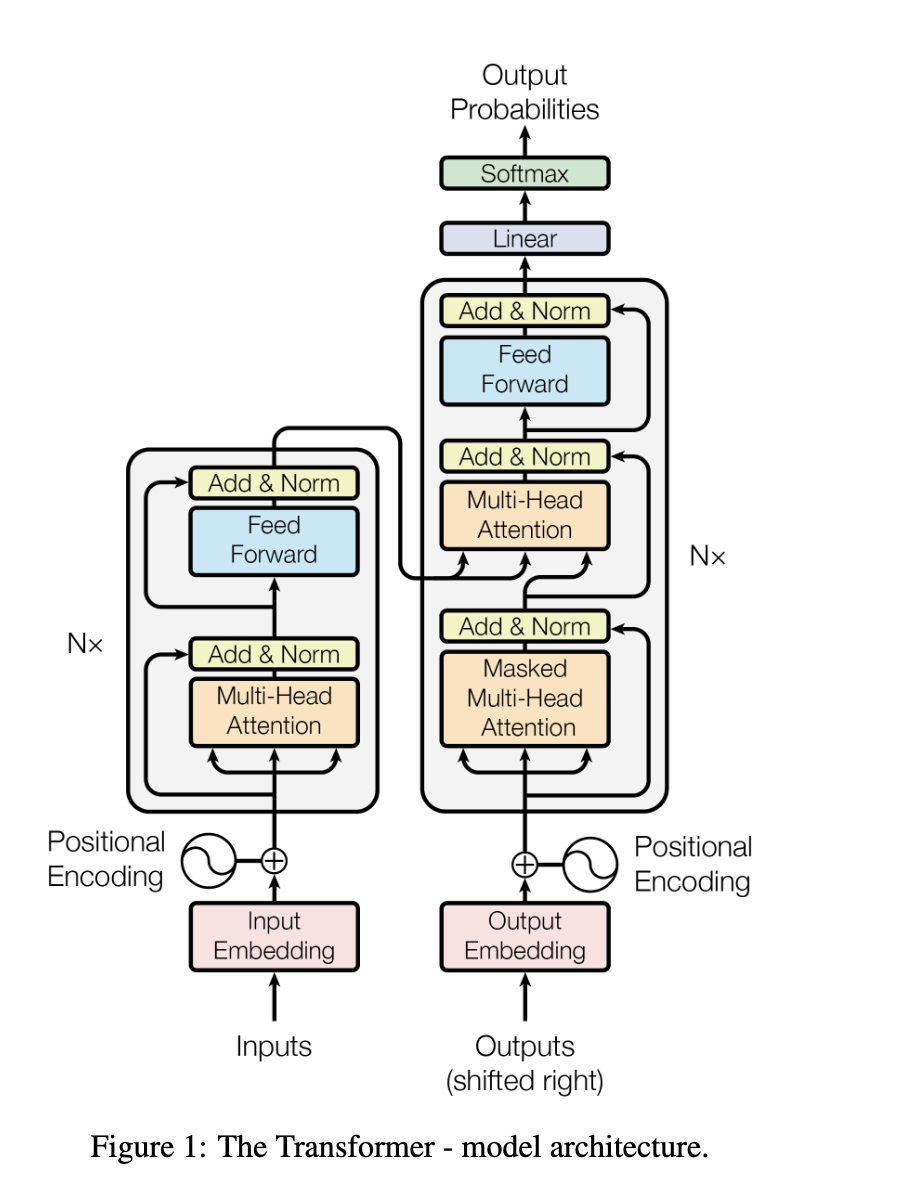

In [11]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super(EncoderLayer, self).__init__()
        self.attention = MultiHeadAttention(d_model, num_heads)
        self.ffn = PositionwiseFeedForward(d_model, d_ff, dropout)
        self.layernorm1 = nn.LayerNorm(d_model)
        self.layernorm2 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, x, mask):
        attn_weight, attn_output = self.attention(x, x, x, mask)
        x = self.layernorm1(x + self.dropout1(attn_output))
        ffn_output = self.ffn(x)
        return attn_weight, self.layernorm2(x + self.dropout2(ffn_output))

In [12]:
class Encoder(nn.Module):
    def __init__(self, num_layers, d_model, num_heads, d_ff, input_dim, dropout):
        super(Encoder, self).__init__()
        self.d_model = d_model
        self.num_layers = num_layers
        self.embedding = nn.Embedding(input_dim, d_model)
        self.pos_encoding = PositionalEncoding(d_model)
        self.enc_layers = nn.ModuleList([
            EncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])

    def forward(self, x, mask):
        attn_weights = []
        seq_len = x.size(1)
        x = self.embedding(x)
        x = self.pos_encoding(x)

        for i in range(self.num_layers):
            attn_weight, x = self.enc_layers[i](x, mask)
            attn_weights.append(attn_weight)

        return attn_weights, x

## Decoder

In [13]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super(DecoderLayer, self).__init__()
        self.attention1 = MultiHeadAttention(d_model, num_heads)
        self.attention2 = MultiHeadAttention(d_model, num_heads)
        self.ffn = PositionwiseFeedForward(d_model, d_ff, dropout)
        self.layernorm1 = nn.LayerNorm(d_model)
        self.layernorm2 = nn.LayerNorm(d_model)
        self.layernorm3 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.dropout3 = nn.Dropout(dropout)

    def forward(self, x, enc_output, tgt_mask, src_tgt_mask):
        # Self-attention
        attn_weight1, attn_output1 = self.attention1(x, x, x, tgt_mask)
        x = self.layernorm1(x + self.dropout1(attn_output1))
        # Encoder-decoder attention
        attn_weight2, attn_output2 = self.attention2(x, enc_output, enc_output, src_tgt_mask)
        x = self.layernorm2(x + self.dropout2(attn_output2))

        ffn_output = self.ffn(x)
        return attn_weight1, attn_weight2, self.layernorm3(x + self.dropout3(ffn_output))

In [14]:
class Decoder(nn.Module):
    def __init__(self, num_layers, d_model, num_heads, d_ff, target_dim, dropout):
        super(Decoder, self).__init__()
        self.d_model = d_model
        self.num_layers = num_layers
        self.embedding = nn.Embedding(target_dim, d_model)
        self.pos_encoding = PositionalEncoding(d_model)
        self.dec_layers = nn.ModuleList([
            DecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])

    def forward(self, x, enc_output, tgt_mask, src_tgt_mask):
        self_attn_weights = []
        enc_attn_weights = []

        seq_len = x.size(1)
        x = self.embedding(x)
        x = self.pos_encoding(x)

        for i in range(self.num_layers):
            self_attn_weight, enc_attn_weight, x = self.dec_layers[i](x, enc_output, tgt_mask, src_tgt_mask)
            self_attn_weights.append(self_attn_weight)
            enc_attn_weights.append(enc_attn_weight)

        return self_attn_weights, enc_attn_weights, x

## Transformer

In [15]:
class Transformer(nn.Module):
    def __init__(self, num_layers, d_model, num_heads, d_ff, input_dim, target_dim, dropout, tgt_vocab_size):
        super(Transformer, self).__init__()
        self.encoder = Encoder(num_layers, d_model, num_heads, d_ff, input_dim, dropout)
        self.decoder = Decoder(num_layers, d_model, num_heads, d_ff, target_dim, dropout)
        self.generator = nn.Linear(d_model, tgt_vocab_size)
        self.attention_weights = {}

    def forward(self, enc_input, dec_input):
        enc_mask = self.make_pad_mask(enc_input, enc_input)
        tgt_mask = self.make_tgt_mask(dec_input)
        src_tgt_mask = self.make_pad_mask(dec_input, enc_input)

        # print('ENCODER')
        enc_self_attn, enc_output = self.encoder(enc_input, enc_mask)

        # print('DECODER')
        dec_self_attn, dec_enc_attn, dec_output = self.decoder(dec_input, enc_output, tgt_mask, src_tgt_mask)

        # save attn_weights
        self.attention_weights = {
            "enc_self_attn": enc_self_attn,
            "dec_self_attn": dec_self_attn,
            "dec_enc_attn": dec_enc_attn
        }

        output = self.generator(dec_output)
        output = F.log_softmax(output, dim=-1)
        return output

    def make_pad_mask(self, query, key, pad_idx=0):
        # query: (n_batch, query_seq_len)
        # key: (n_batch, key_seq_len)
        query_seq_len, key_seq_len = query.size(1), key.size(1)

        key_mask = key.ne(pad_idx).unsqueeze(1).unsqueeze(2)  # (n_batch, 1, 1, key_seq_len)
        key_mask = key_mask.repeat(1, 1, query_seq_len, 1)    # (n_batch, 1, query_seq_len, key_seq_len)

        query_mask = query.ne(pad_idx).unsqueeze(1).unsqueeze(3)  # (n_batch, 1, query_seq_len, 1)
        query_mask = query_mask.repeat(1, 1, 1, key_seq_len)  # (n_batch, 1, query_seq_len, key_seq_len)

        mask = key_mask & query_mask
        mask.requires_grad = False
        return mask

    def make_subsequent_mask(self, query, key):
        # query: (n_batch, query_seq_len)
        # key: (n_batch, key_seq_len)
        query_seq_len, key_seq_len = query.size(1), key.size(1)

        tril = np.tril(np.ones((query_seq_len, key_seq_len)), k=0).astype('uint8') # lower triangle without diagonal
        mask = torch.tensor(tril, dtype=torch.bool, requires_grad=False, device=query.device)
        return mask

    def make_tgt_mask(self, tgt):
        pad_mask = self.make_pad_mask(tgt, tgt)
        seq_mask = self.make_subsequent_mask(tgt, tgt)
        mask = pad_mask & seq_mask
        return pad_mask & seq_mask



# Training

### Optimizer
- Adam.
- 하이퍼파라미터:
    - $\beta_1 = 0.9$
    - $\beta_2 = 0.98$
    - $\epsilon = 10^{-9}$


### 학습률 변화
- 수식:  
    $
    \text{lrate} = d_{\text{model}}^{-0.5} \cdot \min(\text{step\_num}^{-0.5}, \text{step\_num} \cdot \text{warmup\_steps}^{-1.5})
    $
- $\text{warmup\_steps} = 4000$


### Regularization
  - Residual Dropout:
    - 서브 계층의 출력에 dropout 적용.
    - 임베딩과 위치 인코딩 합에도 dropout 적용.
    - 기본 모델에서 사용된 dropout 비율: 0.1
  - Label Smoothing:
    - $\epsilon_{\text{ls}} = 0.1$ 사용.


In [16]:
# Hyperparameters
num_layers = 6  # Transformer 레이어 수
d_model = 512  # 모델의 차원
num_heads = 8  # 멀티헤드 어텐션 헤드 수
d_ff = 2048  # 피드포워드 네트워크의 차원
input_dim = 10000  # 입력 단어 수 (예: 어휘 크기)
target_dim = 10000  # 타겟 단어 수 (예: 어휘 크기)
dropout_rate = 0.1
num_steps = 100000  # 훈련 스텝 수
warmup_steps = 4000  # 워밍업 스텝 수
epsilon_ls = 0.1  # 레이블 스무딩 값

# Adam Optimizer
beta1 = 0.9
beta2 = 0.98
epsilon = 1e-9

In [17]:
def get_learning_rate(step_num):
    return d_model ** -0.5 * min(step_num ** -0.5, step_num * warmup_steps ** -1.5)

device = "cuda" if torch.cuda.is_available() else "cpu"
model = Transformer(num_layers, d_model, num_heads, d_ff, input_dim, target_dim, dropout_rate, len(de_vocab)).to(device)

criterion = nn.CrossEntropyLoss(label_smoothing=epsilon_ls)
optimizer = optim.Adam(model.parameters(), lr=0)

In [18]:
for step_num in range(1, num_steps + 1):
    iterator = tqdm.tqdm(train_loader)
    for batch in iterator:
        src = batch['en_ids'].to(device)
        tgt = batch['de_ids'].to(device)

        # print(f'src: {src.shape}, dtype: {src.dtype}')
        # print(f'tgt: {tgt.shape}, dtype: {tgt.dtype}')
        # print(f'tgt[:, :-1]: {tgt[:, :-1].shape}, dtype: {tgt[:, :-1].dtype}')

        optimizer.zero_grad()
        output = model(src, tgt[:, :-1])

        # print(f'output dtype: {output.dtype}')
        # print(f'output shape: {output.shape}')
        # print(f'tgt[:, 1:]: {tgt[:, 1:].shape}, values: {tgt[:, 1:]}')

        loss = criterion(output.view(-1, output.size(-1)), tgt[:, 1:].contiguous().view(-1))

        loss.backward()
        optimizer.step()

        # Learning rate update
        lr = get_learning_rate(step_num)
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr

        if step_num % 1000 == 0:
            iterator.set_description(f'Step: {step_num}, Loss: {loss.item()}, Learning Rate: {lr}')

 38%|███▊      | 87/227 [00:09<00:15,  8.97it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

 59%|█████▉    | 135/227 [00:14<00:10,  9.01it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

 60%|█████▉    | 136/227 [00:15<00:10,  9.05it/s]


KeyboardInterrupt: 

# Testing

In [59]:
model.eval()
with torch.no_grad():
    epoch_loss = 0
    for batch in test_loader:
        src = batch["en_ids"].to(device)
        trg = batch["de_ids"].to(device)  # trg로 변경

        output = model(src, trg[:, :-1])
        output_dim = output.shape[-1]

        # trg로 변경하여 손실 계산
        loss = criterion(output.view(-1, output_dim), trg[:, 1:].contiguous().view(-1))
        epoch_loss += loss.item()

print(f'Test Loss: {epoch_loss / len(test_loader)}')

Test Loss: 1.2272410839796066


# Visualization

학습을 도중에 중단해서 올바른 어텐션 맵이 나오진 않았음.

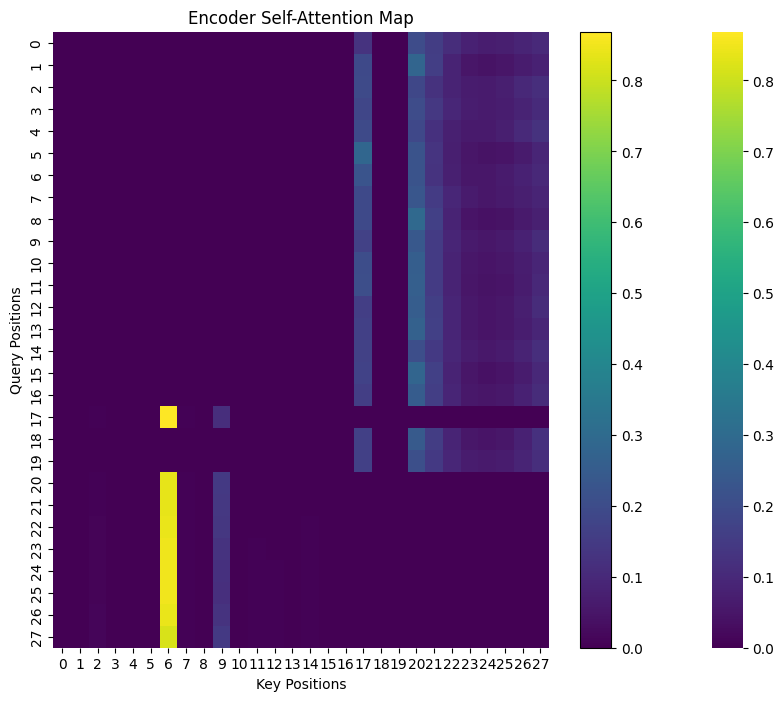

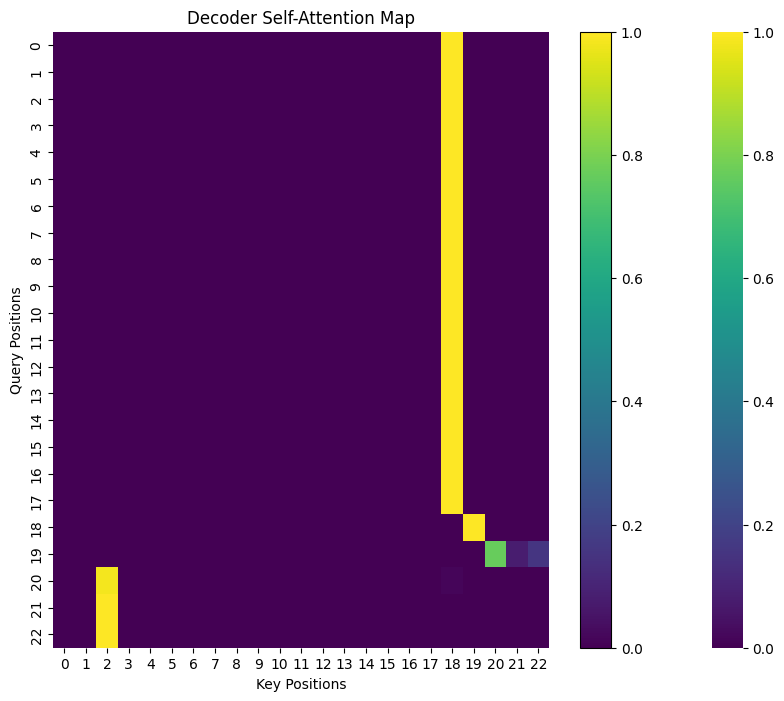

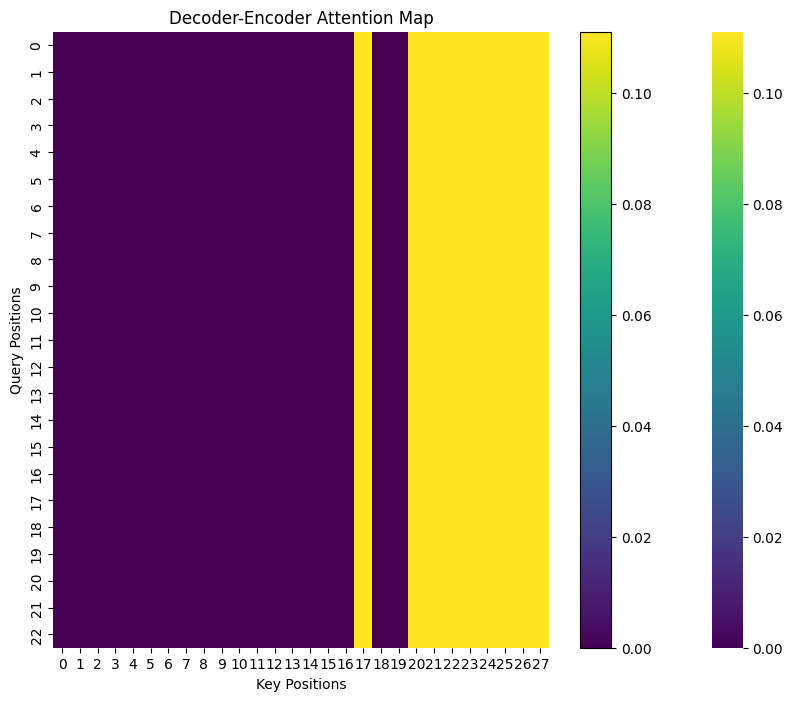

In [56]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns


def plot_attention_map(attention_weights, title):
    plt.figure(figsize=(10, 8))
    heatmap = sns.heatmap(attention_weights, cmap='viridis', cbar=True)
    plt.title(title)
    plt.xlabel('Key Positions')
    plt.ylabel('Query Positions')
    plt.colorbar(heatmap.collections[0]) 
    plt.show()
for batch in train_loader:
    src = batch['en_ids'].to(device)
    tgt = batch['de_ids'].to(device)

    with torch.no_grad():
        output = model(src, tgt[:, :-1])
    

    if isinstance(model.attention_weights, dict):
        enc_self_attn = model.attention_weights["enc_self_attn"]  
        dec_self_attn = model.attention_weights["dec_self_attn"]
        dec_enc_attn = model.attention_weights["dec_enc_attn"]  
    else: 
        enc_self_attn = model.attention_weights[0] 
        dec_self_attn = model.attention_weights[1]
        dec_enc_attn = model.attention_weights[2]


    # print(enc_self_attn[0][0].detach().cpu().numpy().shape)

    plot_attention_map(enc_self_attn[0][0][0].detach().cpu().numpy(), title='Encoder Self-Attention Map')
    plot_attention_map(dec_self_attn[0][0][0].detach().cpu().numpy(), title='Decoder Self-Attention Map')
    plot_attention_map(dec_enc_attn[0][0][0].detach().cpu().numpy(), title='Decoder-Encoder Attention Map')

    break
